In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV


## Чтение данных

In [170]:
df = pd.read_csv('train.csv')

## Функции для работы с корреляцией между столбами

In [171]:
def print_corr(c):
    plt.figure(figsize=(20, 20))
    sns.heatmap(c, cmap='coolwarm')
    plt.show()

In [172]:
def most_corr(data, target):
    correlation = data.corr()
    print_corr(correlation)
    x = correlation[correlation[target].between(0.45, 1, inclusive="neither")].index
    print(x)

## Препроцессинг

- Удаление столбцов с объектами
- Заполнение пропусков медианой
- Удаление выбросов
- Логарифмирование целевого столбца y
- Нормализация MinMax

In [173]:
def prepoc(data, target=None):
    data = data.drop(columns=['region', 'osm_city_nearest_name', 'city', 'street', 'id', 'date'])
    data = data.fillna(data.median())
    # df = df.dropna()
    if target is not None:
        data = del_emissions(data)
    X = data

    if target is not None:
        # Y = data[target]
        Y = np.log2(data[target])
        X = data.drop(columns=[target])
    else:
        Y = None
    scaler = preprocessing.MinMaxScaler().fit(X)
    X = scaler.transform(X)
    # if target is not None:
    #     most_corr(data, target)
    return X, Y


## Функция удаления выбросов

In [174]:
def del_emissions(df):
    #find Q1, Q3, and interquartile range for each column
    Q1 = df.quantile(q=.25)
    Q3 = df.quantile(q=.75)
    IQR = df.apply(stats.iqr)

    #only keep rows in dataframe that have values within 1.5\*IQR of Q1 and Q3
    data_clean = df[((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return data_clean


## One-hot encoding

Но я его не использовал, тк были проблемы с памятью

In [175]:
# df = df.join(pd.get_dummies(df['region'], prefix='region_'))
# df = df. join(pd.get_dummies(df['osm_city_nearest_name'], prefix='city_nearest_'))
# df = df.join(pd.get_dummies(df['city'], prefix='city_'))
# df = df.join(pd.get_dummies(df['street'], prefix='street_'))
# df.info()


C:\Users\marse\AppData\Local\Temp\ipykernel_7000\1311614584.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(df['per_square_meter_price'])


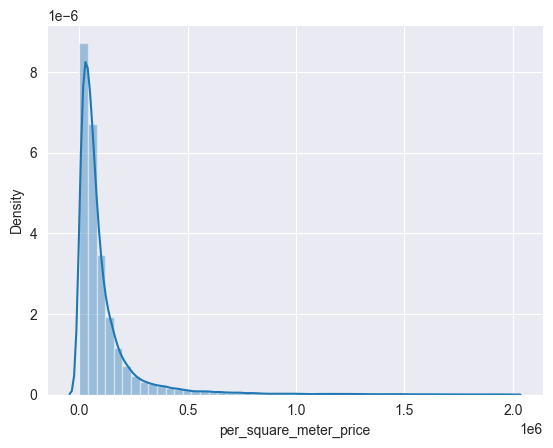

In [176]:
sns_plot = sns.distplot(df['per_square_meter_price'])
fig = sns_plot.get_figure()

In [177]:
X, Y = prepoc(df, 'per_square_meter_price')
Y = Y.to_list()


C:\Users\marse\AppData\Local\Temp\ipykernel_7000\3376031383.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(Y)


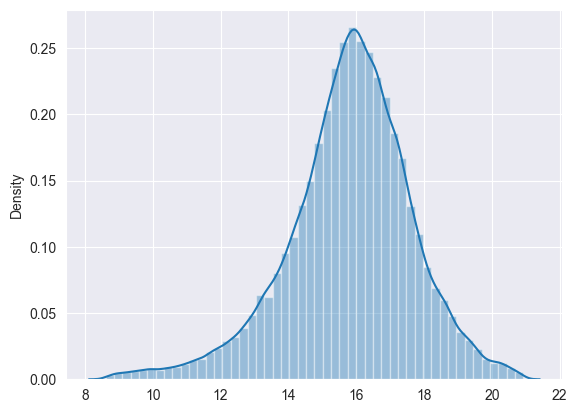

In [178]:
sns_plot = sns.distplot(Y)
fig = sns_plot.get_figure()

In [179]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


In [180]:
def tuning(X_train, y_train):
    n_iter = [1000]
    eta0 = [0.1, 0.01]
    alpha = [0.0001, 0.00001]
    learning_rate = ['invscaling', 'optimal', 'adaptive']
    #Convert to dictionary
    hyperparameters = dict(max_iter=n_iter, eta0=eta0, alpha=alpha, learning_rate=learning_rate)
    #Create new KNN object
    sgd_model = SGDRegressor()
    #Use GridSearch
    clf = GridSearchCV(sgd_model, hyperparameters)
    best_model = clf.fit(X_train, y_train)
    #Print The value of best Hyperparameters
    print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
    print('Best eta0:', best_model.best_estimator_.get_params()['eta0'])
    print('Best alpha:', best_model.best_estimator_.get_params()['alpha'])
    print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])

In [181]:
def pred(x, y, x_tested, y_tested=None):
    n_iter = 1000
    # eta0 = 0.1
    # alpha = 1e-5
    clf_ = SGDRegressor(max_iter=n_iter, learning_rate='adaptive')
    clf_.fit(x, y)
    y_pred = clf_.predict(x_tested)
    if y_tested is not None:
        plt.scatter(y_tested, y_pred)
        plt.grid()
        plt.xlabel('Actual y')
        plt.ylabel('Predicted y')
        plt.title('Scatter plot from actual y and predicted y')
        plt.show()

        print('MAPE :', mean_absolute_percentage_error(y_tested, y_pred))
    return clf_, y_pred

In [182]:
tuning(x_train, y_train)

C:\Users\marse\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\marse\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\marse\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\marse\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

Best max_iter: 1000
Best eta0: 0.01
Best alpha: 1e-05
Best learning_rate: adaptive


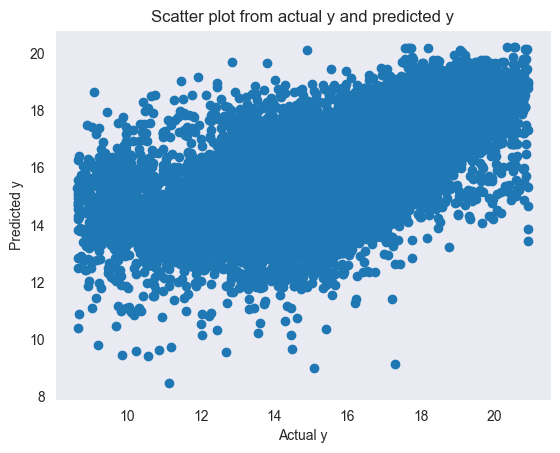

MAPE : 0.0650923694513527


In [183]:
model, y_ = pred(x_train, y_train, x_test, y_test)

## Работа с тестовой выборкой

- обучение на всем тренировочном датасете

In [184]:
df_begin = pd.read_csv('test_x.csv')
df_end, y = prepoc(df_begin)
model.fit(X, Y)
result = model.predict(df_end)

In [185]:
df_end.shape

(68825, 69)

In [186]:
df_begin.shape

(68825, 75)

In [187]:
result_data = {'per_square_meter_price': 2 ** result, 'id': df_begin.index}
result_df = pd.DataFrame.from_dict(result_data)
result_df.to_csv('result.csv', index=False)